In [446]:
#imports
from datetime import datetime as dt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

### Loading Datasets

In [447]:
# file path
file_path="C:/Users/Davie/Desktop/introduction-to-power-bi/"

In [448]:
#load demographic data
demographic=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='CustomerDemographic', index_col=False, header=0, usecols="A:M", skiprows=1)

In [449]:
#load customer address
address=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='CustomerAddress', index_col=False, header=0, usecols="A:F", skiprows=1)

In [450]:
#load transaction data
transactions=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='Transactions', index_col=False, header=0, usecols="A:M", skiprows=1)

### Merging the datasets

In [451]:
#merge demographic data with customer address
demographic_address=pd.merge(demographic, address, on='customer_id', how='inner')

In [452]:
#merged all the 3 datasets
demographic_address_transactions=pd.merge(demographic_address, transactions, on='customer_id', how='inner')

In [453]:
#drop duplicates and ulls
df=demographic_address_transactions.drop_duplicates().dropna()

In [454]:
#make copy of the data
data=df.copy()

### Feature engineering

In [455]:
#calculate profit margin
data['profit_margin']=data['list_price']-data['standard_cost']

In [456]:
#calculate product margin
data['product_margin']=(data['list_price']-data['standard_cost'])/data['list_price']

In [457]:
# Calculate age

# convert DOB to datetime
data['DOB']=pd.to_datetime(data['DOB'])
# Get the current date
current_date = pd.to_datetime('today')
# Calculate age using apply and a lambda function to handle the year difference
data['age'] = df['DOB'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)))

In [458]:
# Define age bins and labels
bins = [0, 25, 35, 45, 55, 65, 100]
labels = ['0-25','25-35', '35-45', '45-55', '55-65', 'Above 65']

# Create age groups
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

In [459]:
# date of transaction
data['transaction_date'] = pd.to_datetime(data['transaction_date'])

# Extract the daya, monthand year from transaction_date
data['trans_day'] = data['transaction_date'].dt.day
data['trans_month'] = data['transaction_date'].dt.month

In [460]:
# Replace values for gender and state in the entire DataFrame
data['gender'] = data['gender'].replace({'Femal': 'Female', 'F': 'Female'})
data['state']=data['state'].replace({'New South Wales':'NSW','Victoria':'VIC'})

### Distribution for Bikes Purchased to be used as the target variable

<Axes: ylabel='Frequency'>

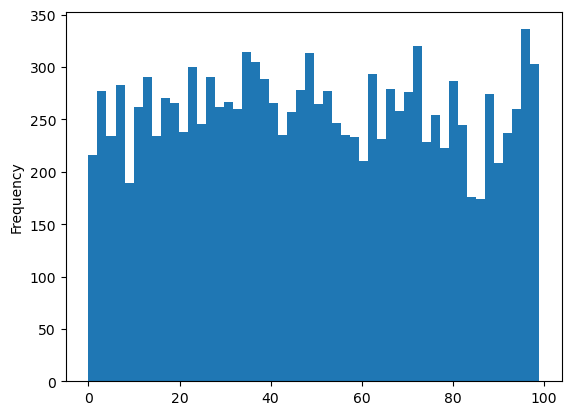

In [461]:
#histogram
data['past_3_years_bike_related_purchases'].plot.hist(bins=50)

<Axes: >

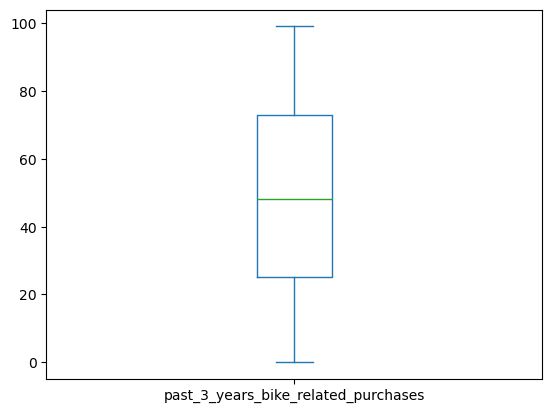

In [462]:
#box plot
data['past_3_years_bike_related_purchases'].plot.box()

### Columns

In [463]:
#checking new columns
data.columns

Index(['customer_id', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'default', 'owns_car', 'tenure', 'address', 'postcode', 'state',
       'country', 'property_valuation', 'transaction_id', 'product_id',
       'transaction_date', 'online_order', 'order_status', 'brand',
       'product_line', 'product_class', 'product_size', 'list_price',
       'standard_cost', 'product_first_sold_date', 'profit_margin',
       'product_margin', 'age', 'age_group', 'trans_day', 'trans_month'],
      dtype='object')

In [464]:
#select columns to use in the Model
cols=['gender','age_group', 'state', 'job_industry_category','job_title', 'online_order', 'order_status' ,'wealth_segment',  'brand','product_line', 'product_class', 'product_size', 'tenure', 'past_3_years_bike_related_purchases', 'property_valuation', 'profit_margin', 'product_margin']

In [465]:
#select model columns
data=data[cols]

In [466]:
#drop nulls
data_clean=data.dropna()

### Encoding
- Choose the encoding method based on the nature of your data and the requirements of your machine learning model. 
- `One-hot encoding` is suitable when there is no ordinal relationship between categories
- `label encoding` is useful when there is an ordinal relationship between categories. 
- **Example**
    - Label encoding for Ordinal Variables
    - `ordinal_mapping_prod_size = {'small': 0, 'medium': 1, 'large': 2} #product size`
    - `ordinal_data['product_size'] = ordinal_data['product_size'].map(ordinal_mapping_prod_size)`
    - `data.reset_index(drop=True, inplace=True)`  # Reset index of X without adding it as a new column
- Always remember to handle unknown categories appropriately, especially when using one-hot encoding.

In [467]:
# Creating binary variable from continous variable

#create threshold
threshold=data_clean['past_3_years_bike_related_purchases'].median()
# create high buyers and low buyers
data_clean['bikes_purchased']=(data_clean['past_3_years_bike_related_purchases']>threshold).astype(int)
#drop past_3_years_bike_related_purchases column
data_clean=data_clean.drop(columns=['past_3_years_bike_related_purchases'])

In [468]:
# Select categorical columns
categorical_ordinal = ['product_class', 'product_size']

# Initialize LabelEncoder
label_encoder = LabelEncoder(

# Apply Label Encoding to each column
for col in categorical_ordinal:
    data_clean[col] = label_encoder.fit_transform(data_clean[col])

In [482]:
# Select categorical columns
categorical_nominal = ['gender', 'age_group','state', 'job_industry_category', 'job_title', 
                    'order_status', 'wealth_segment', 'brand', 'product_line', 'property_valuation']

# Initialize the OneHotEncoder
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Apply the one-hot encoder to the categorical columns
encoded_features = onehot_encoder.fit_transform(data_clean[categorical_nominal])

# Convert the encoded features into a DataFrame
encoded_data = pd.DataFrame(encoded_features, columns=onehot_encoder.get_feature_names_out(categorical_nominal))
encoded_data.reset_index(drop=True, inplace=True)

# Drop the original categorical columns and concatenate the one-hot encoded columns
data = data_clean.drop(categorical_nominal, axis=1)
data.reset_index(drop=True, inplace=True)
model_data = pd.concat([data, encoded_data], axis=1)

# Display the updated DataFrame
model_data.dropna()

,gender,age_group,online_order,product_class,product_size,tenure,property_valuation,profit_margin,product_margin,bikes_purchased,...,brand_Giant Bicycles,brand_Norco Bicycles,brand_OHM Cycles,brand_Solex,brand_Trek Bicycles,brand_WeareA2B,product_line_Mountain,product_line_Road,product_line_Standard,product_line_Touring
0,0,5,0.0,2,1,11.0,10,110.56,0.469210,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,5,1.0,2,1,11.0,10,751.02,0.476073,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,5,1.0,1,2,11.0,10,189.28,0.110002,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,5,0.0,2,1,11.0,10,90.10,0.250000,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,5,0.0,2,1,11.0,10,17.87,0.249965,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,1,2,0.0,1,1,19.0,9,114.93,0.200003,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
12966,1,2,1.0,0,2,19.0,9,182.81,0.109999,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12967,0,2,1.0,2,1,18.0,5,448.68,0.319686,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12968,0,2,1.0,2,1,18.0,5,143.82,0.250004,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [484]:
# Select relevant features and the target variable
X = model_data.drop(columns=['bikes_purchased'])
y = model_data['bikes_purchased']

In [471]:
'''# Identify categorical and numerical columns
categorical_features = ['gender', 'age_group', 'state', 'job_industry_category', 'job_title', 
                        'order_status', 'wealth_segment', 'brand', 'product_line', 'product_class', 'product_size']'''
numerical_features = ['product_margin', 'profit_margin', 'property_valuation']

"# Identify categorical and numerical columns\ncategorical_features = ['gender', 'age_group', 'state', 'job_industry_category', 'job_title', \n                        'order_status', 'wealth_segment', 'brand', 'product_line', 'product_class', 'product_size']"

### RANDOM FOREST CLASSIFICATION

In [488]:
# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Combine preprocessing steps for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'  # Keep all other columns as they are (already preprocessed/one-hot encoded)
)

# Create a pipeline with RandomForestClassifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 95.41%
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1324
           1       0.96      0.94      0.95      1270

    accuracy                           0.95      2594
   macro avg       0.95      0.95      0.95      2594
weighted avg       0.95      0.95      0.95      2594

Confusion Matrix:
[[1277   47]
 [  72 1198]]


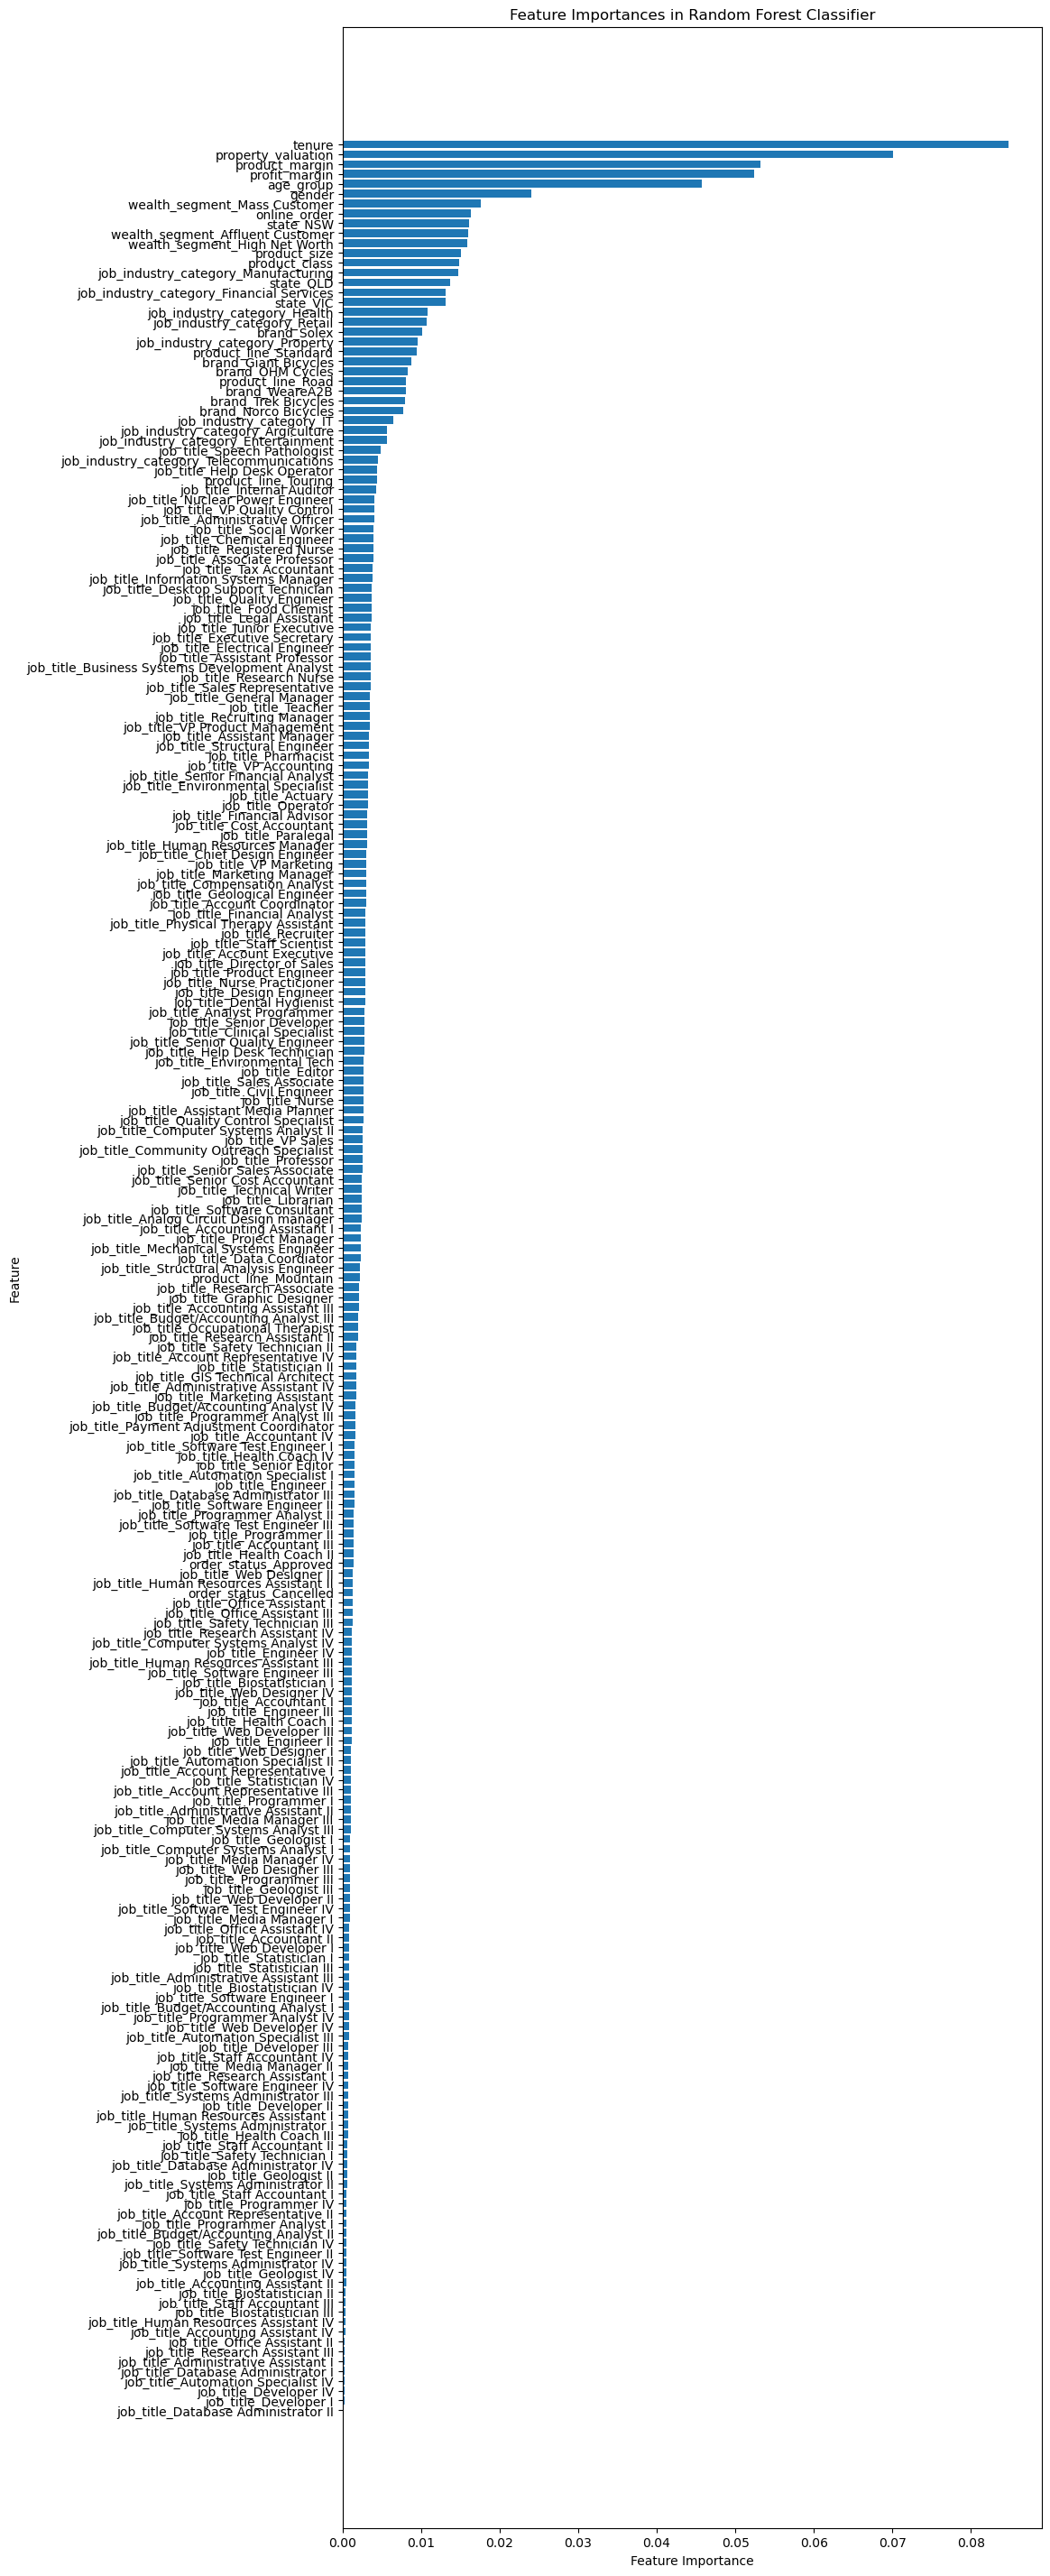

In [489]:

# Visualize feature importances
# Get feature importances from the trained model
feature_importances = model.named_steps['classifier'].feature_importances_

# Get feature names (numerical + already one-hot encoded features)
feature_names = numerical_features + [col for col in X.columns if col not in numerical_features]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 36))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Classifier')
plt.gca().invert_yaxis()
plt.show()


### LINEAR RGRESSION

In [490]:
# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'  # Keep all other columns as they are (already preprocessed/one-hot encoded)
)
# Create a pipeline with LinearRegression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R^2 Score: {r2_score(y_test, y_pred)}')

Mean Squared Error: 0.23419389989063732
R^2 Score: 0.06281826452618133


### DECISSION TREE

In [495]:
# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical data
#categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'  # Keep all other columns as they are (already preprocessed/one-hot encoded)
)

# Create a pipeline with DecisionTreeRegressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R^2 Score: {r2_score(y_test, y_pred)}')

# Hyperparameter tuning
param_grid = {
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best Mean Squared Error:', -grid_search.best_score_)  # Convert back to positive MSE

# Use the best estimator for predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Final evaluation of the tuned model
print(f'Mean Squared Error (tuned): {mean_squared_error(y_test, y_pred)}')
print(f'R^2 Score (tuned): {r2_score(y_test, y_pred)}')

Mean Squared Error: 0.018118735543562067
R^2 Score: 0.9274936365582701
Best parameters: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Best Mean Squared Error: 0.04028651020266035
Mean Squared Error (tuned): 0.018118735543562067
R^2 Score (tuned): 0.9274936365582701


#### Q: Based on age group, gender, and state, what are the key target demographics for bike purchases?

#### Q2: Predictive Modeling:
- Can you build a model to predict the likelihood of bike purchases based on demographic and product characteristics?

### LOGISTIC REGRESSION
- Logistic regression is used for classification tasks, not regression. Since you want to predict the likelihood of bike purchases, which is a binary classification problem, logistic regression is indeed appropriate.

In [492]:
# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Function to pass through categorical data (no transformation needed since already label encoded)
categorical_transformer = FunctionTransformer(lambda x: x)
'''
# Preprocessing pipeline for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')'''

# Combine preprocessing steps for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'  # Keep all other columns as they are (already preprocessed/one-hot encoded)
)

# Create a pipeline with LogisticRegression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred)}')

Accuracy: 0.5944487278334618
Precision: 0.5809806835066865
Recall: 0.6157480314960629
F1 Score: 0.5978593272171253
ROC AUC Score: 0.5948830791921402


"# Hyperparameter tuning\nparam_grid = {\n    'classifier__C': [0.01, 0.1, 1, 10, 100],\n    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],\n    'classifier__solver': ['lbfgs', 'liblinear', 'saga']\n}\n\ngrid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')\ngrid_search.fit(X_train, y_train)\n\n# Best parameters and score\nprint('Best parameters:', grid_search.best_params_)\nprint('Best ROC AUC Score:', grid_search.best_score_)\n\n# Use the best estimator for predictions\nbest_model = grid_search.best_estimator_\ny_pred = best_model.predict(X_test)\n\n# Final evaluation of the tuned model\nprint(f'Accuracy (tuned): {accuracy_score(y_test, y_pred)}')\nprint(f'Precision (tuned): {precision_score(y_test, y_pred)}')\nprint(f'Recall (tuned): {recall_score(y_test, y_pred)}')\nprint(f'F1 Score (tuned): {f1_score(y_test, y_pred)}')\nprint(f'ROC AUC Score (tuned): {roc_auc_score(y_test, y_pred)}')"

# Interpreting the LOGISTIC CLASSIFIER

In [ ]:
# Interpret the model coefficients
# Get the feature names after one-hot encoding and scaling
onehot_columns = model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
all_feature_names = np.hstack([numerical_features, onehot_columns])

# Get the coefficients from the logistic regression model
coefficients = model.named_steps['classifier'].coef_[0]

# Create a DataFrame for the coefficients
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of the coefficient to see the most influential features
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)

print(coef_df)

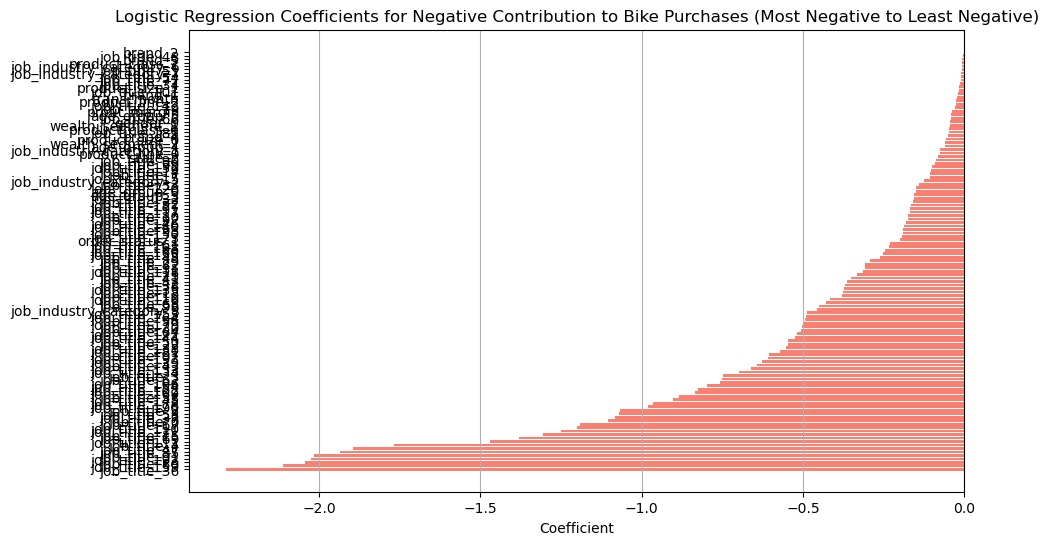

In [493]:
# Filter coefficients for negative contribution to bike purchases
negative_coef_df = coef_df[coef_df['Coefficient'] < 0]

# Sort coefficients in ascending order (from most negative to least negative)
negative_coef_df = negative_coef_df.sort_values(by='Coefficient', ascending=True)

# Plot the coefficients for negative contribution to bike purchases
plt.figure(figsize=(10, 6))
plt.barh(negative_coef_df['Feature'], negative_coef_df['Coefficient'], color='salmon')
plt.xlabel('Coefficient')
plt.title('Logistic Regression Coefficients for Negative Contribution to Bike Purchases (Most Negative to Least Negative)')
plt.grid(axis='x')
plt.show()

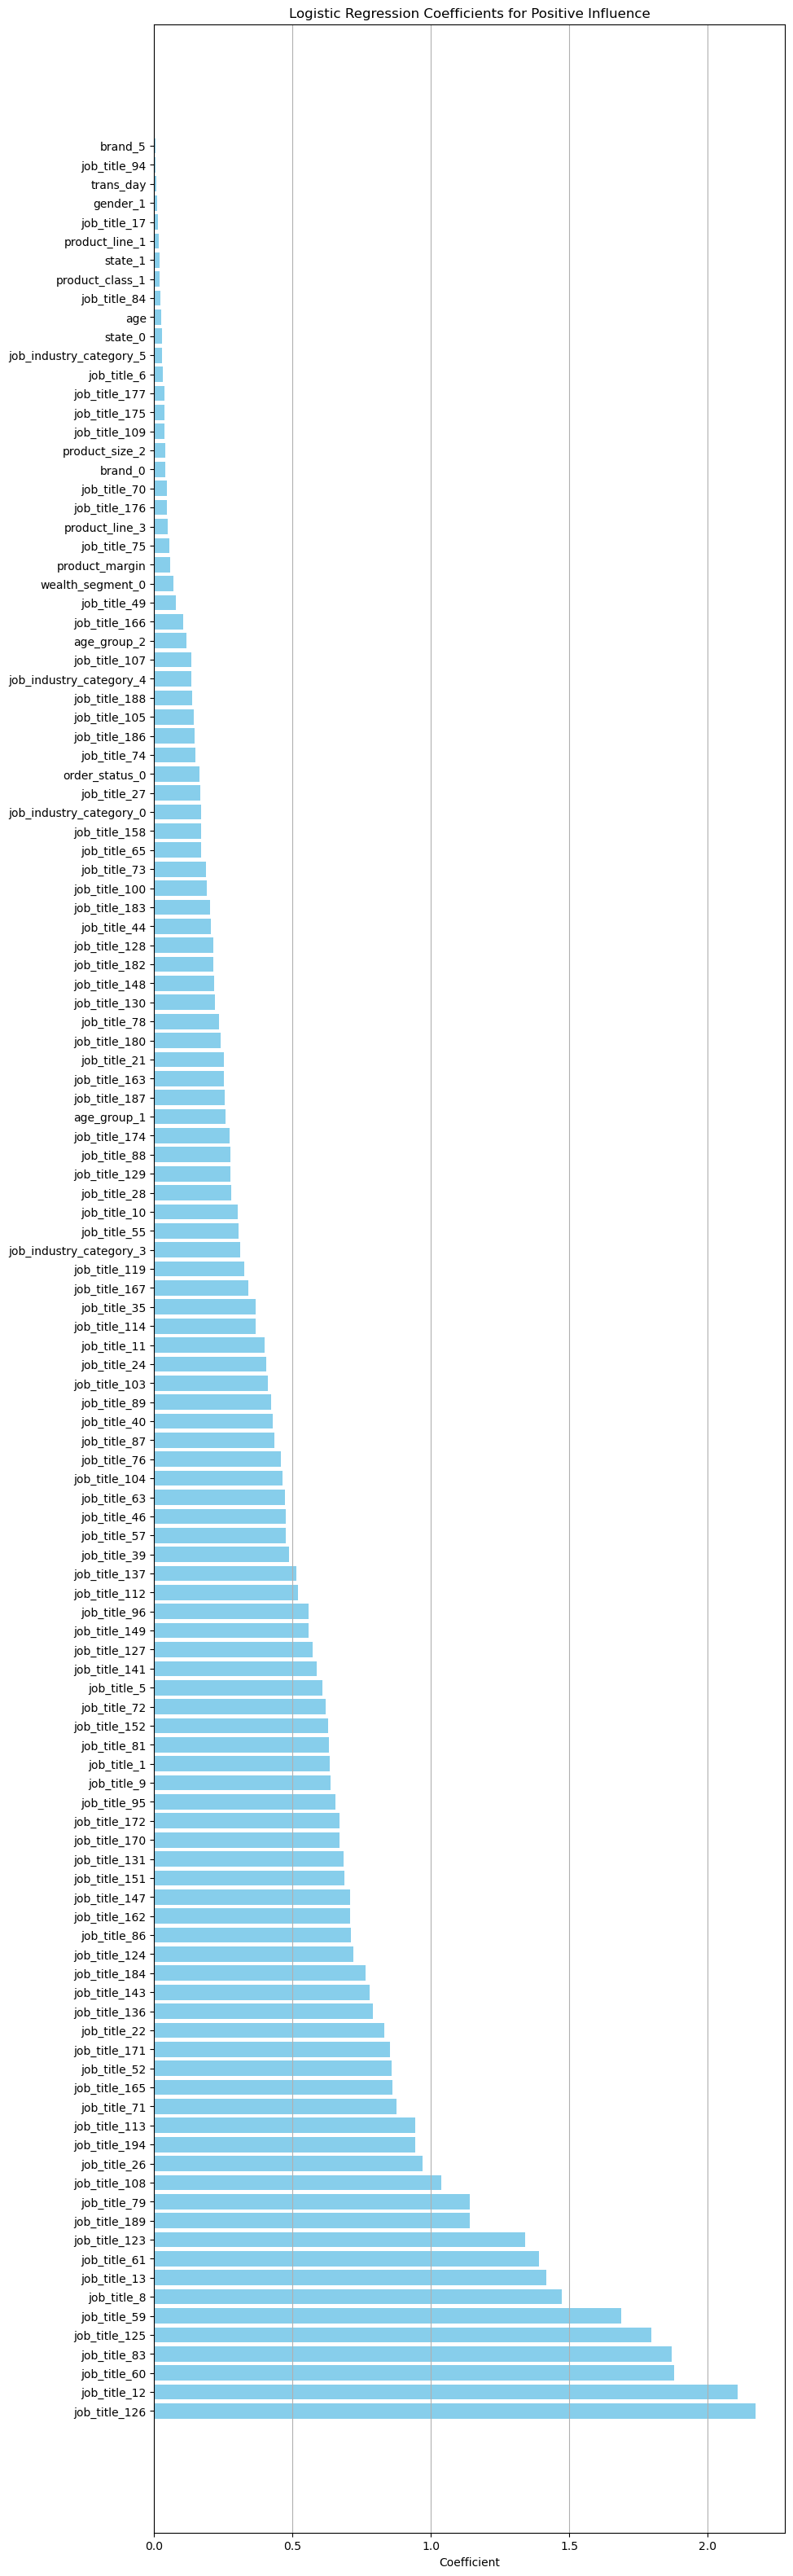

In [494]:
# Filter coefficients for positive influence
positive_coef_df = coef_df[coef_df['Coefficient'] > 0]

# Sort coefficients in descending order
positive_coef_df = positive_coef_df.sort_values(by='Coefficient', ascending=False)

# Plot the coefficients for positive influence
plt.figure(figsize=(10, 40))
plt.barh(positive_coef_df['Feature'], positive_coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Logistic Regression Coefficients for Positive Influence')
plt.grid(axis='x')
plt.show()

- Use RandomForestRegressor when your target variable is a continuous value that you need to predict.
- Use RandomForestClassifier when your target variable is a categorical label or class.